In [1]:
"""
Final Python script for visualizing satellite data using the Community Earth System model (CESM).
This script was developed under the supervision of Dr. Marysa Laguë as one of the final components of Andre Bergeron's 
summer 2024 research project for the Research Experience in ALpine Meteorology (REALM) REU program at the University of Utah
"""

# August 1st, 2024 | Andre Bergeron | Data retrieved from Dr. Marysa Laguë, PhD. | University of Utah, Department of Atmospheric Sciences  
# This research was supported by the National Science Foundation (Award #2244272) and the Center for High Performance Computing (CHPC) at the University of Utah
# Final energy flux maps for the Pacific Southwest National Ecological Observatory Network (NEON) Domain

"\nFinal Python script for visualizing satellite data using the Community Earth System model (CESM).\nThis script was developed under the supervision of Dr. Marysa Laguë as one of the final components of Andre Bergeron's \nsummer 2024 research project for the Research Experience in ALpine Meteorology (REALM) REU program at the University of Utah\n"

In [2]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt

sys.path.append('./scripts')

import datetime
import glob
import multiprocessing
import os
import pickle as pickle
import sys
import time
from copy import copy

import cartopy
import cartopy.crs as ccrs
import cftime
import dask
import dask.bag as db
import IPython.core.display as di 
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.axes_size as Size
import netCDF4 as nc
import numpy as np
import numpy.ma as mak
import numpy.matlib
import pandas as pd
import scipy as sp
import scipy.io as sio
import xarray as xr
from cartopy.util import add_cyclic_point
from IPython.display import HTML, display

from matplotlib import gridspec, ticker
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
from numpy import ma
from scipy import interpolate, stats
from shapely.geometry.polygon import LinearRing
from sklearn import linear_model
from windspharm.standard import VectorWind

In [3]:
### Take a new subset of the time array and assign the new array to the coordinates of the dataset
def cesm_time(ds):

    time2 = cftime.num2date(ds['time'].values[:]-15, units=ds['time'].units,
                            calendar=ds['time'].calendar,only_use_cftime_datetimes=True)
    
    ds = ds.assign_coords({'time':time2})
    ds = ds.where(ds['time'].dt.year.isin(range(21,80)),drop=True)

    return ds

In [4]:
"""
Function computes the difference between the normal distribution of trees (trees) with a simulated tree die-off scenario (notrees)
and plots the results onto a bar graph using matplotlib
"""

'\nFunction computes the difference between the normal distribution of trees (trees) with a simulated tree die-off scenario (notrees)\nand plots the results onto a bar graph using matplotlib\n'

In [5]:
def map_energy_fluxes(ds_notrees, ds_trees, title=None, cb_ttl=None, cmap=plt.cm.get_cmap('RdBu_r', 32), clim=[-1,1]):

    
    fluxes = ['FSDS', 'FSUS', 'FLDS', 'FLUS', 'LHFLX', 'SHFLX']
    names = ['Shortwave down', 'Shortwave up', 'Longwave down', 'Longwave up', 'Latent heat', 'Sensible heat']
   
    ### compute the difference between the normal distribution of trees (trees) with a simulated tree die-off scenario (notrees)
    for x in range(len(fluxes)):
        var = fluxes[x]
        if var == 'FLUS':
            ts_notrees = (ds_notrees['FLDS'] - ds_notrees['FLNS']).groupby('time.year').mean('time')
            ts_trees = (ds_trees['FLDS'] - ds_trees['FLNS']).groupby('time.year').mean('time')
            
        elif var == 'FSUS':
            ts_notrees = (ds_notrees['FSDS'] - ds_notrees['FSNS']).groupby('time.year').mean('time')
            ts_trees = (ds_trees['FSDS'] - ds_trees['FSNS']).groupby('time.year').mean('time')

        else:
            ts_notrees = ds_notrees[var].groupby('time.year').mean('time')
            ts_trees = ds_trees[var].groupby('time.year').mean('time')

        mapdata = ts_notrees.mean('year') - ts_trees.mean('year')
        
        ### Display areas where the results of the t-test are greater than a p-value of 1
        t,p = stats.ttest_ind(ts_notrees.values,ts_trees.values,axis=0)
        sigmask = np.where(p<1,1.0,np.nan)
        mapdata_masked = mapdata*sigmask
            
        central_lat = 37.5
        central_lon = -120
        extent = [-125, -115, 30, 45]
        central_lon = np.mean(extent[:2])
        central_lat = np.mean(extent[2:])
        
        ### Plot the climate data results to the PlateCarree map projection with a set extent and add scale bar
        ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))       
        ax.set_extent(extent)
        cs = ax.pcolormesh(ds_trees.lon.values, ds_trees.lat.values, mapdata_masked, transform=ccrs.PlateCarree(), zorder = 0)        
        ax.add_feature(cartopy.feature.STATES.with_scale('10m'), linewidth = 0.75, edgecolor = 'k', zorder = 1)
        
        
        ### Plot map features 
        ax.set_title('%s'%names[x], fontsize=16, y=1.05)
        ax.gridlines()                

        if clim:
            plt.cm.ScalarMappable.set_clim(cs,vmin = clim[0],vmax = clim[1])

        if cmap:
            plt.set_cmap(copy(cmap))
        else:
            plt.set_cmap(copy(plt.cm.viridis))

        if clim:
            plt.cm.ScalarMappable.set_clim(cs,vmin = clim[0],vmax = clim[1])

        cm = plt.get_cmap()

        plt.show()
        plt.close()

    return ax,cs,cm

In [6]:
### reads filepath and declares variables that dictate which section of the data is to be used

filepath = '/uufs/chpc.utah.edu/common/home/lague-group1/data/EAGER'
ctrl_name = 'ctrl_smallpert'
case_name = 'nd17'

In [7]:
### concatonates filepath to the specific data to be used and takes the means for a certain time period
ctrl_files_atm = sorted(glob.glob(filepath + '/' + ctrl_name + '/means_100/*.cam.h0.20-99_year*.nc'))
case_files_atm_NW = sorted(glob.glob(filepath + '/' + case_name + '/means_100/*.cam.h0.20-99_year*.nc'))

In [8]:
### opens the data from the filepath and assigns the control coordinate units to the experiment variable
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        
    ds_ctrl_atm = cesm_time(xr.open_mfdataset(ctrl_files_atm, decode_times=False))
    ds_case_atm_NW = cesm_time(xr.open_mfdataset(case_files_atm_NW, decode_times=False))
    
    ds_case_atm_NW = ds_case_atm_NW.assign_coords({'lat':ds_ctrl_atm.lat.values,'lon':ds_ctrl_atm.lon.values})
    
    ds_case_NW = xr.merge([ds_case_atm_NW])
    ds_ctrl = xr.merge([ds_ctrl_atm])

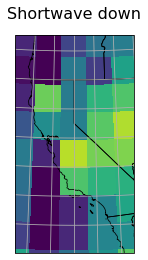

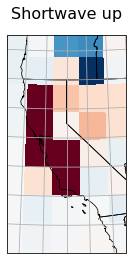

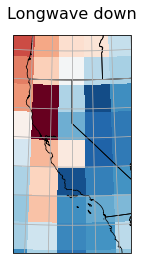

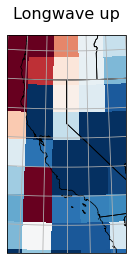

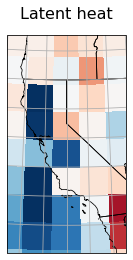

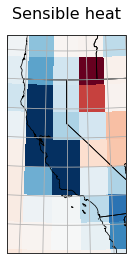

(<GeoAxesSubplot:title={'center':'Sensible heat'}>,
 <matplotlib.colors.LinearSegmentedColormap at 0x7f22cddf04c0>)

In [9]:
map_energy_fluxes(ds_case_NW, ds_ctrl)